In [1]:
# 내장 라이브러리
import glob
import pathlib

# 외부 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


pd.options.display.float_format = '{:0,.2f}'.format

sns.set_palette('husl')
sns.set_style('whitegrid')

plt.rcParams['font.family'] ='D2Coding'
plt.rcParams['axes.unicode_minus'] =False

DAY_OF_WEEK = ['월', '화', '수', '목', '금', '토', '일']
BASE_DIR = pathlib.Path('../').resolve()


# 데이터를 병합하여 하나의 데이터프레임 형성

files = glob.glob(str(BASE_DIR / '실습' / 'rawfiles' / 'CARD_SUBWAY_MONTH_*.csv'))

print('Files:\n'+'\n'.join(files)+'\n')

Files:
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201903.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201902.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201901.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201905.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201904.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201906.csv



In [2]:
df_subway_raw = pd.concat([pd.read_csv(filename) for filename in files])
df_subway_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107028 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   사용일자    107028 non-null  int64  
 1   노선명     107028 non-null  object 
 2   역명      107028 non-null  object 
 3   승차총승객수  107028 non-null  float64
 4   하차총승객수  107028 non-null  float64
 5   등록일자    107028 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


In [3]:
df = df_subway_raw.copy()

df['승차총승객수'] = df['승차총승객수'].astype(int)
df['하차총승객수'] = df['하차총승객수'].astype(int)

df_subway = df.copy()

np.random.seed(0)
df.sample(20)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
6234,20190611,경춘선,퇴계원,4404,4075,20190614
16251,20190628,1호선,온양온천,4757,4889,20190701
10344,20190218,4호선,상록수,20839,20546,20190221
3310,20190206,경춘선,가평,1881,1662,20190209
13946,20190324,경춘선,대성리,5666,652,20190327
11715,20190320,2호선,사당,33209,28596,20190323
634,20190502,2호선,신대방,33293,31885,20190505
6530,20190112,2호선,잠실새내,22579,24271,20190115
2606,20190205,분당선,서현,6991,7644,20190208
2513,20190305,경의선,효창공원앞,8689,8629,20190308


In [4]:
df = df_subway[df_subway['노선명'] == '1호선']

df = df.groupby(['역명']) \
    .aggregate({
        '승차총승객수': 'sum',
        '하차총승객수': 'sum',
    }) \
    .reset_index()

df['승하차총승객수 차'] = df['승차총승객수'] - df['하차총승객수']
df['승하차총승객수 차 절댓값'] = abs(df['승하차총승객수 차'])
df.sort_values(by='승하차총승객수 차 절댓값', ascending=False)

,역명,승차총승객수,하차총승객수,승하차총승객수 차,승하차총승객수 차 절댓값
39,부평,6924006,7531774,-607768,607768
1,가산디지털단지,10111317,10571381,-460064,460064
62,영등포,9042814,9432067,-389253,389253
78,주안,4354709,3966481,388228,388228
76,종각,7905054,7517515,387539,387539
...,...,...,...,...,...
82,직산,167984,173994,-6010,6010
32,배방,201462,195569,5893,5893
29,망월사,1677889,1680615,-2726,2726
30,명학,1816147,1818478,-2331,2331


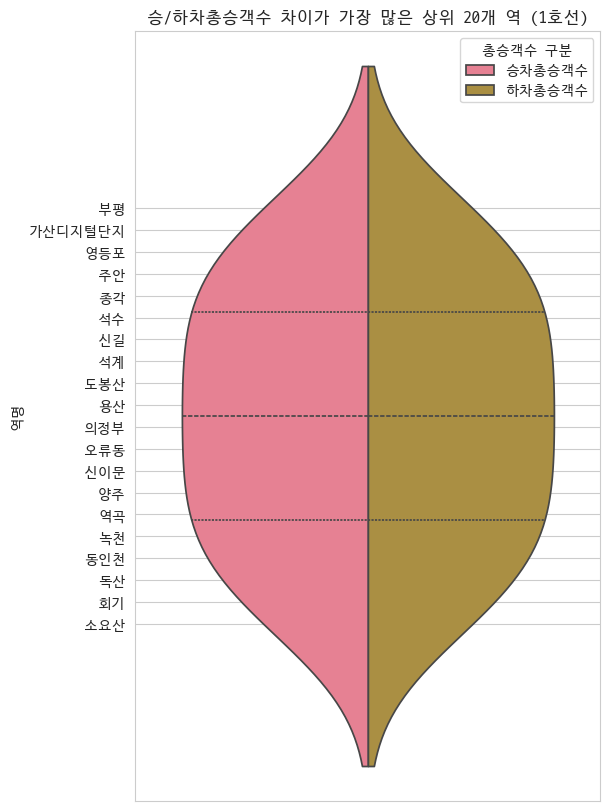

In [5]:
def get_df(df: pd.DataFrame, n: int) -> pd.DataFrame:
    # 승차총승객수와 하차총승객수를 '총승객수'와 '총승객수 구분'으로 변환
    return df \
        .nlargest(n, '승하차총승객수 차 절댓값') \
        .melt(
            id_vars=['역명'],
            value_vars=['승차총승객수', '하차총승객수'],
            var_name='총승객수 구분',
            value_name='총승객수',
        )


# Violin plot 작성
plt.figure(figsize=(6, 10))
plt.title('승/하차총승객수 차이가 가장 많은 상위 20개 역 (1호선)')
sns.violinplot(
    data=get_df(df, 20),
    y='역명',
    hue='총승객수 구분',
    inner='quart',
    split=True,
)
plt.show()